# Next level development of new infrastructure based on TDI filter
In the new structure, PCI and TDI filters share a common infrastructure.  We develop that infrastrucutre here using the TDI kernels, as TDI is well understood, and can be compared with a well-established result.

Key common elements for development and testing are the common infrastructure for estimating sensitivities and for interpolating results from time-local kernels for application across a wider temporal stretch of data.


In [1]:
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi import Data
import h5py
import numpy as np
import copy
import pcipy
from pcipy.data import TimeData
from pcipy.tdi_filter import DeducedTDIFilter as TDIFilter

## Read in data sets

In [2]:
if 0:
    datadir = "/data/jgbaker/software/pylisa/data/"
    orbits = datadir+"keplerian-orbits.h5"
    workdir = datadir+"/simulations/"
    noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
    gw_file_base = "2025-07-01_19h34_"
if 1:
    datadir = "/data/jgbaker/software/pcipy/data"
    workdir = datadir+"/simulations/"
    if 1:
        orbits = workdir+"keplerian-orbits.h5"
        noise_file_base = "2025-04-07_keplerian_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_keplerian_"
    else:
        orbits = workdir+"equalarm-orbits.h5"
        noise_file_base = "2025-04-07_equalarm_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_equalarm_"

skip=1000


#### Basic single-link noise data

In [3]:
noise_sim_path = workdir+noise_file_base+"measurements_4Hz.h5"

#get the central frequency
sim = h5py.File(noise_sim_path, 'r')
central_freq = sim.attrs['central_freq']
sim.close()

data_noise = Data.from_instrument(noise_sim_path)
fs = data_noise.fs

in_chans=["isi","rfi","tmi"]

#in_chans=["isi"]
in_chansGW=["isi"]

def make_names(in_chans):
    mosas_order = ['12', '23', '31', '13', '21', '32']
    names=[]
    for chan in in_chans:
        for link in mosas_order:
            names.append(f'{chan}_{link}')
    return names

#setup instrumental channels
y_names = make_names(in_chans)
#we have to divide by central_freq because the instument sumlation channels are in beat-rate units
y_list = [data_noise.measurements[name]/central_freq for name in y_names]
y_n = TimeData(np.array(y_list, dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names=y_names)

You are using a measurement file in a version that might not be fully supported


#### Matching GW simulations results for the empirical sensitivity calculation

In [4]:
gw_path = workdir+gw_file_base+"gw_measurements_4Hz.h5"

data_gw = Data.from_gws(gw_path,orbits)

y_namesGW = make_names(in_chansGW)
#note: the GW mesaurement data are already fractional frequency so we don't divide by central_freq
y_list = [data_gw.measurements[name] for name in y_namesGW]
display(y_list)
np.array(y_list, dtype=np.float64)
y_gw = TimeData(np.array(y_list, dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names=y_namesGW)

You are using a GW file in a development version
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported


[array([ 0.85221103,  0.64236179, -0.660586  , ..., -1.94593982,
         0.17747689, -1.66847782], shape=(1036800,)),
 array([-0.36785764,  0.01970518,  0.14511895, ..., -0.04970868,
        -0.09606979, -0.48545533], shape=(1036800,)),
 array([ 0.77215357, -1.36680461, -0.05450318, ..., -0.3160359 ,
        -0.77210703, -0.91221723], shape=(1036800,)),
 array([-2.14420271, -0.91742178,  0.76044897, ...,  0.28165959,
        -1.94137956, -1.92178592], shape=(1036800,)),
 array([-0.03011097,  0.01204994, -0.17068137, ...,  0.00808109,
         0.08929396,  0.2333917 ], shape=(1036800,)),
 array([ 0.08427693, -0.57987423,  1.91482474, ...,  0.00591381,
        -0.06678223,  1.68501076], shape=(1036800,))]

#### For comparison, we also need the TDI data

In [5]:
#TDI noise from file
tdipath2 = workdir +  noise_file_base + 'noise_tdi2_4Hz.h5'

tdi2 = h5py.File(tdipath2, 'r')
x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq
tdi2.close()

XYZ_file_noise = TimeData(np.array([x2_noise,y2_noise,z2_noise], dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names='XYZ')

#GW
tdi2_gw_file = workdir+gw_file_base+"gw_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()] #/ central_freq  (gw simulation already in fractional freq)
y2_gw = hdf5['y'][()] #/ central_freq
z2_gw = hdf5['z'][()] #/ central_freq
hdf5.close()

XYZ_file_gw = TimeData(np.array([x2_gw,y2_gw,z2_gw], dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names='XYZ')


#### Define data range for this study and set up fourier transforms

In [6]:
range_in_hours = 8
ibuff=250   #edge buffer for kernels 

ns = int(range_in_hours * 3600 * fs) # less for dev

In [7]:
#new infrastructure
if 1:
    def get_range(td,istart,iend):
        #extract a subset of a TD (to be added to TD)
        print(td.data.shape)
        newdata = td.data[:,istart:iend]
        #print('-->',newdata.shape)
        newt0=None
        newdt=None
        newnames=None
        if td.t0 is not None:
            newt0 = td.t0 + td.dt*istart
        if td.dt is not None:
            newdt = td.dt
        if td.names is not None:
            newnames=td.names
        #print('old t0,dt:',td.t0,td.dt,'new t0,dt:',newt0,newdt)
        return TimeData(newdata,t0=newt0,dt=newdt,names=newnames)
    
    def get_index_at_time(td,time):
        return (time-td.t0)/td.dt
    
    def get_times(td):
        print('t0,dt:',td.t0,td.dt)
        return np.arange(td.n_samples())*td.dt+td.t0
else:
    get_range=TimeData.get_range
    get_index_at_time=TimeData.get_index_at_time
    get_times=TimeData.get_times

In [8]:
#Generate pytdi noise here:
homemade_noise=True
if homemade_noise:  
    data_noise = Data.from_instrument(noise_sim_path)
    if 0:  #Construct exactly as in the orig sims
        
        # Build other 2.0 Michelson variables
        X_data = X2.build(**data_noise.args)
        Y_data = Y2.build(**data_noise.args)
        Z_data = Z2.build(**data_noise.args)

        measurements_hm=data_noise.measurements
        skip_hm=skip
        
    else: #construct on a restricted data range (faster and more like how the kernel is computed
        istart=skip-50
        skip_hm=skip-istart
        imaxend=int((range_in_hours+0.2)*3600*fs)
        newargs=copy.deepcopy(data_noise.args)
        for k in newargs['delays'].keys():
            #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
            newargs['delays'][k]=newargs['delays'][k][istart:imaxend]
            newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][istart:imaxend]
        
        # Build other 2.0 Michelson variables
        X_data = X2.build(**newargs)
        Y_data = Y2.build(**newargs)
        Z_data = Z2.build(**newargs)

        measurements_hm=copy.deepcopy(data_noise.measurements)
        
        for k in measurements_hm.keys():
            print(k)
            measurements_hm[k]=measurements_hm[k][istart:imaxend]
                
    # Apply TDI 2.0
    x_noise = X_data(measurements_hm)/ central_freq
    y_noise = Y_data(measurements_hm)/ central_freq
    z_noise = Z_data(measurements_hm)/ central_freq

    XYZ_homemade_noise = TimeData(np.array([x_noise,y_noise,z_noise], dtype=np.float64)[:,skip_hm:],dt=1/fs,t0=skip/fs,names='XYZ')



You are using a measurement file in a version that might not be fully supported


isi_12
rfi_12
tmi_12
isi_sb_12
rfi_sb_12
isi_23
rfi_23
tmi_23
isi_sb_23
rfi_sb_23
isi_31
rfi_31
tmi_31
isi_sb_31
rfi_sb_31
isi_13
rfi_13
tmi_13
isi_sb_13
rfi_sb_13
isi_32
rfi_32
tmi_32
isi_sb_32
rfi_sb_32
isi_21
rfi_21
tmi_21
isi_sb_21
rfi_sb_21


In [9]:

ytest_n = get_range(y_n,0,ns+2*ibuff)
ytest_gw = get_range(y_gw,0,ns+2*ibuff)

TDItest_n = get_range(XYZ_file_noise,0,ns+2*ibuff)
TDItest_gw = get_range(XYZ_file_gw,0,ns+2*ibuff)

if homemade_noise:
    TDItest_hmn = get_range(XYZ_homemade_noise,0,ns+2*ibuff)

(18, 1035800)
(6, 1035800)
(3, 1035800)
(3, 1035800)
(3, 117079)


              total        used        free      shared  buff/cache   available
Mem:       15911324     3261948    10283708        1276     2365668    12339224
Swap:             0           0           0


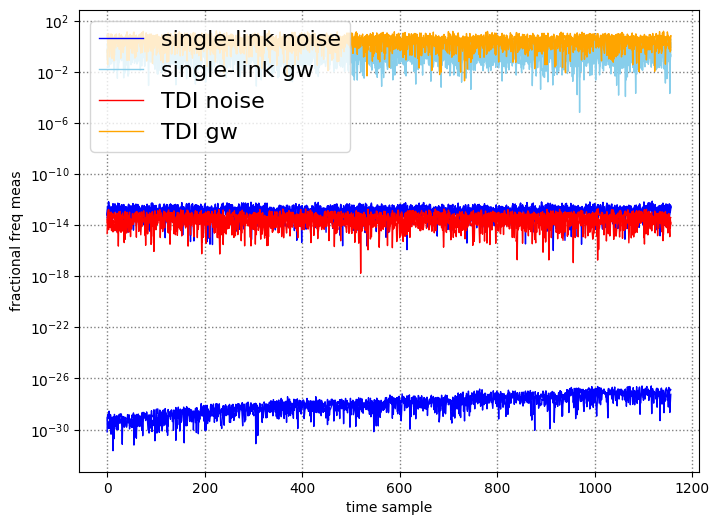

In [10]:
# View data in time domain

import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 100
axes.semilogy(np.abs(ytest_n.data[0,::iev]), linewidth=1, color=colors[0], label='single-link noise')
for i in range(1,6):
    axes.semilogy(np.abs(ytest_n.data[i,::iev]), linewidth=1, color=colors[0])
    
axes.semilogy(np.abs(ytest_gw.data[0,::iev]), linewidth=1, color=colors[1], label='single-link gw')
for i in range(1,6):
    axes.semilogy(np.abs(ytest_gw.data[i,::iev]), linewidth=1, color=colors[1])
    
axes.semilogy(np.abs(TDItest_n.data[0,::iev]), linewidth=1, color=colors[2], label='TDI noise')
for i in range(1,3):
    axes.semilogy(np.abs(TDItest_n.data[i,::iev]), linewidth=1, color=colors[2])

axes.semilogy(np.abs(TDItest_gw.data[0,::iev]), linewidth=1, color=colors[3], label='TDI gw')
for i in range(1,3):
    axes.semilogy(np.abs(TDItest_gw.data[i,::iev]), linewidth=1, color=colors[3])
    
    
axes.set_xlabel("time sample")
axes.set_ylabel(r"fractional freq meas")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 3e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

In [11]:
#Fourier Transform
import pyfftw
from pyfftw.interfaces.numpy_fft import rfft, irfft, fft
pyfftw.interfaces.cache.enable()
# Transform PCI variables to Fourier domain

wd = np.blackman(ns)

## Transform simulated TDI variables to Fourier domain
k2 = np.sum(wd**2)

def do_ft(dataset, fs=fs):
    ns=dataset.n_samples()
    wd=np.blackman(ns)
    f = np.fft.rfftfreq(ns) * fs
    sel=f>0
    #print(sel)
    dataset_fft=[rfft(wd * dataset.data[i] ) * np.sqrt(2/(fs*k2)) for i in range(dataset.n_channels())]
    
    return f[sel], np.array(dataset_fft)[:,sel]

[3.45721694e-05 6.91443388e-05 1.03716508e-04 ... 1.99993086e+00
 1.99996543e+00 2.00000000e+00]
              total        used        free      shared  buff/cache   available
Mem:       15911324     3331256    10214400        1276     2365668    12269916
Swap:             0           0           0


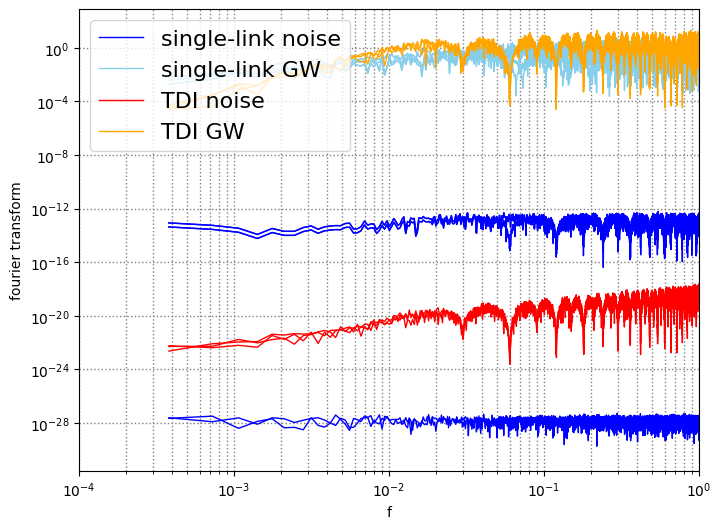

In [12]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 10
i0=iev

f,data=do_ft(ytest_n)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[0], label='single-link noise')
for i in range(1,6):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[0])
    
print(f)    
f,data=do_ft(ytest_gw)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[1], label='single-link GW')
for i in range(1,6):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[1])
    
f,data=do_ft(TDItest_n)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[2], label='TDI noise')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[2])
        
f,data=do_ft(TDItest_gw)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[3], label='TDI GW')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[3])
    
    
axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

## Fixed time TDI filters
We construct TDI filters set for times at points at start, 1/3, 1/2 and 2/3 of the data range 

In [13]:
istep =  ns // 3
i0set = skip+ibuff+np.array([0, istep, ns//2, 2*istep]) #needed in the original time-grid frame
t_eval_set = i0set/fs
nameset=["start","left","center","right"]
display(np.array(i0set))
display(np.array(i0set)/(ns))

array([ 1250, 39650, 58850, 78050])

array([0.01085069, 0.34418403, 0.51085069, 0.67751736])

In [14]:
display(y_n.data.shape)

(18, 1035800)

In [15]:
#Construct filters
import importlib
import pcipy
importlib.reload(pcipy)
importlib.reload(pcipy.tdi_filter)

print(t_eval_set)
TDIfiltset = [ TDIFilter(data_noise,eval_time=t,nleft=400,nright=400,in_chans=in_chans) for t in t_eval_set ]
t0set = np.array( [ filt.kernel_ref_time for filt in TDIfiltset ] )

TDIfiltset_lin_kern = [ TDIFilter(data_noise,eval_time=t,nleft=400,nright=400,in_chans=in_chans,method='linear') for t in t_eval_set ]

display(t_eval_set)
display(t0set)
#TDIfilt=TDIFilter(data_noise,i0=1000)

[  312.5  9912.5 14712.5 19512.5]
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0


array([  312.5,  9912.5, 14712.5, 19512.5])

array([  347.75,  9947.75, 14747.75, 19547.75])

In [16]:
for filt in TDIfiltset:
    display(filt.__dict__)

{'in_chans': ['isi', 'rfi', 'tmi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'input_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(282),
 'kernel_ref_time': np.float64(347.75),
 'n_input_channels': 18,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.24478841e-11,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.07569913e-09,  0.00000000e+00,  0.00000000e+00],

{'in_chans': ['isi', 'rfi', 'tmi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'input_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(282),
 'kernel_ref_time': np.float64(9947.75),
 'n_input_channels': 18,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.24390457e-11,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.07540765e-09,  0.00000000e+00,  0.00000000e+00]

{'in_chans': ['isi', 'rfi', 'tmi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'input_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(282),
 'kernel_ref_time': np.float64(14747.75),
 'n_input_channels': 18,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.24346336e-11,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.07526215e-09,  0.00000000e+00,  0.00000000e+00

{'in_chans': ['isi', 'rfi', 'tmi'],
 'mosas_order': ['12', '23', '31', '13', '21', '32'],
 'in_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'input_names': ['isi_12',
  'isi_23',
  'isi_31',
  'isi_13',
  'isi_21',
  'isi_32',
  'rfi_12',
  'rfi_23',
  'rfi_31',
  'rfi_13',
  'rfi_21',
  'rfi_32',
  'tmi_12',
  'tmi_23',
  'tmi_31',
  'tmi_13',
  'tmi_21',
  'tmi_32'],
 'dt': np.float64(0.25),
 't0': None,
 'nright': np.int64(0),
 'nleft': np.int64(282),
 'kernel_ref_time': np.float64(19547.75),
 'n_input_channels': 18,
 'n_output_channels': 3,
 'kernel_compts': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.24302263e-11,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.07511680e-09,  0.00000000e+00,  0.00000000e+00

In [17]:
#Apply filters

XYZset = [ filt.apply_filter(ytest_n,method='convolve') for filt in TDIfiltset ]

XYZset_lin_kern = [ filt.apply_filter(ytest_n,method='convolve') for filt in TDIfiltset_lin_kern ]


              total        used        free      shared  buff/cache   available
Mem:       15911324     3365384    10180228        1276     2365712    12235776
Swap:             0           0           0


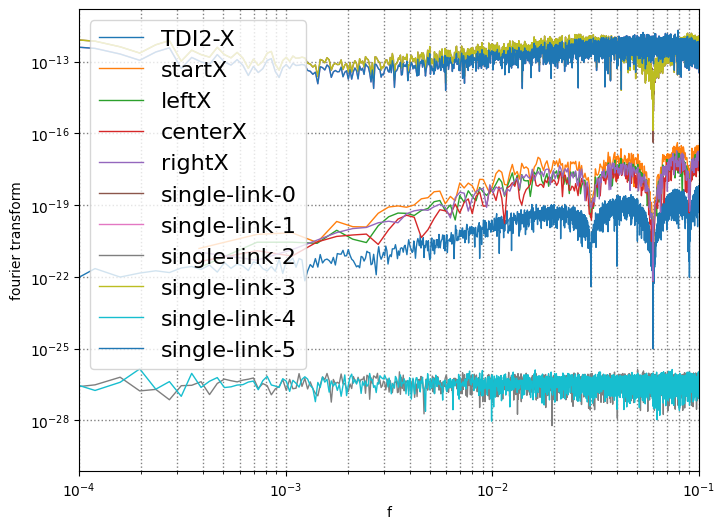

In [18]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 10
i0=iev

ixyz=0

f,data=do_ft(XYZ_file_noise)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset)):
    f,data=do_ft(XYZset[iset])
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])
    
if 0:
    f,dataL=do_ft(XYZset[1])
    f,dataR=do_ft(XYZset[3])
    data=dataR-dataL
    print(np.min(data),np.max(data),np.mean(data))
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label='R-L-diff-'+'XYZ'[ixyz])
            

for iy in range(6):
    f,data=do_ft(y_n)
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))
    

axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

[  347.75  9947.75 14747.75 19547.75]
115200 115418
t0,dt: 250.0 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 250.0 0.25
              total        used        free      shared  buff/cache   available
Mem:       15911324     3220012    10325600        1276     2365712    12381148
Swap:             0           0           0


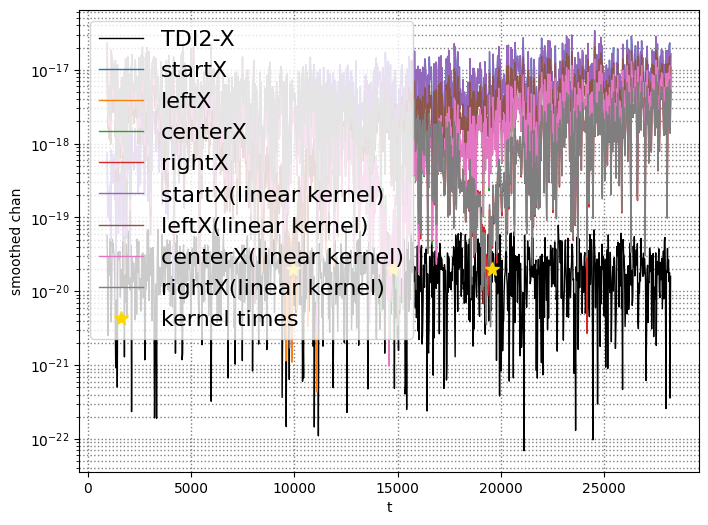

In [19]:
import scipy
# View data in decimated in the time domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

idec = 10
iev=10

ixyz=0
iskip=249

#eps=(iskip+np.arange(XYZset[0].n_samples()))/fs

print(t0set)
print(ns,XYZset[0].n_samples())

do_dec=lambda x:scipy.signal.decimate(x,q=idec)[ibuff:-ibuff]
#epsd=do_dec(eps[:])

#print(eps.shape,TDItest_n.data[ixyz][249:].shape)
data=do_dec(TDItest_n.data[ixyz][iskip:])
times=do_dec(get_times(TDItest_n)[iskip:])
axes.semilogy(times[::iev], np.abs(data[::iev]), c='k', linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset)):
    data=do_dec(XYZset[iset].data[ixyz])
    times=do_dec(get_times(XYZset[iset]))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])

if 1:    
    for iset in range(len(XYZset_lin_kern)):
        data=do_dec(XYZset_lin_kern[iset].data[ixyz])
        times=do_dec(get_times(XYZset_lin_kern[iset]))
        axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz]+"(linear kernel)")

if 1:
    idxs=[int(get_index_at_time(TDItest_n,t)) for t in t0set[1:4]]
    axes.plot(get_times(TDItest_n)[idxs],[2e-20]*3,'*',markersize=10,c='gold',label='kernel times')
                
    
if 0:
    f,dataL=do_ft(XYZset[1])
    f,dataR=do_ft(XYZset[3])
    data=dataR-dataL
    print(np.min(data),np.max(data),np.mean(data))
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label='R-L-diff-'+'XYZ'[ixyz])
            

#for iy in range(6):
#    f,data=do_ft(y_n)
#    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))
    

axes.set_xlabel(r"t")
axes.set_ylabel(r"smoothed chan")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

[  347.75  9947.75 14747.75 19547.75]
115200 115418
t0,dt: 250.0 0.25
t0,dt: 250.0 0.25
t0,dt: 320.5 0.25
timecheck: [0. 0. 0. 0. 0.]
(11042,) (11042,)
t0,dt: 320.5 0.25
timecheck (linK): 3 [0.24713827 0.24713827 0.24713827 0.24713827 0.24713827]
t0,dt: 250.0 0.25
              total        used        free      shared  buff/cache   available
Mem:       15911324     3219804    10325792        1276     2365728    12381368
Swap:             0           0           0


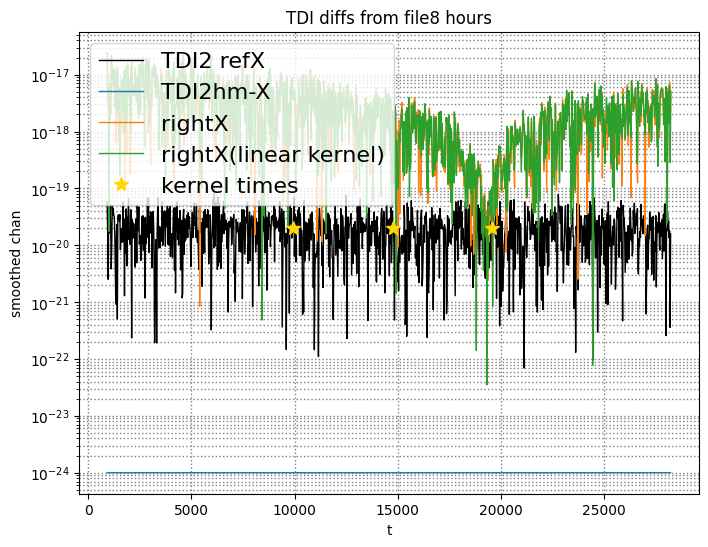

In [20]:
import scipy
# View data in decimated in the time domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

idec = 10
iev=10

ixyz=0
iskip=249

use_homemade=False
#eps=(iskip+np.arange(XYZset[0].n_samples()))/fs

print(t0set)
print(ns,XYZset[0].n_samples())

do_dec=lambda x:scipy.signal.decimate(x,q=idec)[ibuff:-ibuff]
#epsd=do_dec(eps[:])

#print(eps.shape,TDItest_n.data[ixyz][249:].shape)
istop=len(TDItest_n.data[ixyz])-33
if homemade_noise and use_homemade:
    data=do_dec(TDItest_hmn.data[ixyz][iskip:istop])
    times=do_dec(get_times(TDItest_hmn)[iskip:])
else:
    data=do_dec(TDItest_n.data[ixyz][iskip:istop])
    times=do_dec(get_times(TDItest_n)[iskip:])   
dataref=data
axes.semilogy(times[::iev], np.abs((data)[::iev]), c='k', linewidth=1, label='TDI2 ref'+'XYZ'[ixyz])

if homemade_noise:
    if use_homemade:
        data=do_dec(TDItest_n.data[ixyz][iskip:istop])
        times=do_dec(get_times(TDItest_n)[iskip:])   
        data=data-dataref[:len(data)]
        axes.semilogy(times[::iev], np.abs((data)[::iev])+1e-24, linewidth=1, label='TDI2file-'+'XYZ'[ixyz])
    else:
        data=do_dec(TDItest_hmn.data[ixyz][iskip:istop])
        times=do_dec(get_times(TDItest_hmn)[iskip:])   
        data=data-dataref[:len(data)]
        axes.semilogy(times[::iev], np.abs((data)[::iev])+1e-24, linewidth=1, label='TDI2hm-'+'XYZ'[ixyz])


for iset in range(3,len(XYZset)):
    nadj=0
    data=do_dec(XYZset[iset].data[ixyz][nadj:])
    times=do_dec(get_times(XYZset[iset])[nadj:])
    timesref=times
    print('timecheck:',times[:5]-timesref[:5])
    print(data.shape,dataref.shape)
    data=data-dataref#[:len(data)]
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])

if 1:    
    for iset in range(3,len(XYZset_lin_kern)):
        nadj=1
        data=do_dec(XYZset_lin_kern[iset].data[ixyz][nadj:])
        times=do_dec(get_times(XYZset_lin_kern[iset])[nadj:])
        print('timecheck (linK):',iset,times[:5]-timesref[:5])
        data=data-dataref[:len(data)]
        axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz]+"(linear kernel)")

if 1:
    idxs=[int(get_index_at_time(TDItest_n,t)) for t in t0set[1:4]]
    axes.plot(get_times(TDItest_n)[idxs],[2e-20]*3,'*',markersize=10,c='gold',label='kernel times')
                
    

#for iy in range(6):
#    f,data=do_ft(y_n)
#    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))
    

axes.set_xlabel(r"t")
axes.set_ylabel(r"smoothed chan")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 0.1])
plt.title("TDI diffs from file" + str(int(ns/fs/3600))+" hours")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

In [21]:
TDIFilter=pcipy.tdi_filter.DeducedTDIFilter

def linear_interp_data(channel_sets,kernel_times):
    #This function produces an output channel set from two input time-domain channel sets by linear interpolation
    #Each of the two input channels is treated as corresponding to a specific kernel_time and the
    #output should match that channel at that time.  At other times, the output is a linar interpolant
    #The output times are the same as channel set times
    times = get_times(channel_sets[0])
    eps = (times-kernel_times[0])/(kernel_times[1]-kernel_times[0])
    return TimeData(channel_sets[0].data*(1-eps) + channel_sets[1].data*eps, channel_sets[0].dt, channel_sets[0].t0, channel_sets[0].names)


#XYZ_center = TDIfilt_center.apply_filter(ytest,method='convolve')


nsnew=XYZset[0].n_samples()
ioff=125
skip=ibuff

#eps = np.array([ (ioff-skip+i-istep)/istep for i in range(nsnew)])
#eps = (get_times(XYZset[0])-t0set[1])/(t0set[3]-t0set[1])
#XYZlin =  TimeData(XYZset[1].data*(1-eps) + XYZset[3].data*eps, XYZset[0].dt, XYZset[0].t0, XYZset[0].names)
XYZlin = linear_interp_data(XYZset[1:4:2],t0set[1:4:2])
XYZlin_pk = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]+1000)
XYZlin_mk = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]-1000)
XYZlin_pc = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]+100)
XYZlin_mc = linear_interp_data(XYZset[1:4:2],t0set[1:4:2]-100)

XYZlin_lin_kern = linear_interp_data(XYZset_lin_kern[1:4:2],t0set[1:4:2])


print(XYZlin.data.shape,XYZset[0].data.shape)



t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
(3, 115418) (3, 115418)


[  347.75  9947.75 14747.75 19547.75]
115200 115418
t0,dt: 250.0 0.25
t0,dt: 250.0 0.25
t0,dt: 320.5 0.25
t0,dt: 320.5 0.25
t0,dt: 250.0 0.25
t0,dt: 320.5 0.25
              total        used        free      shared  buff/cache   available
Mem:       15911324     3224028    10321568        1276     2365728    12377144
Swap:             0           0           0


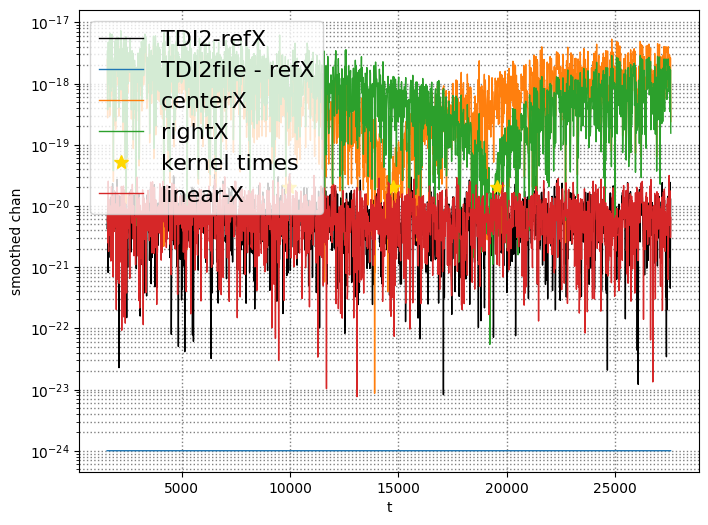

In [22]:
import scipy
# View data in decimated in the time domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

idec = 20
iev=3

ixyz=0
iskip=249

#eps=(iskip+np.arange(XYZset[0].n_samples()))/fs

print(t0set)
print(ns,XYZset[0].n_samples())

do_dec=lambda x:scipy.signal.decimate(x,q=idec)[ibuff:-ibuff]
#epsd=do_dec(eps[:])

istop=len(TDItest_n.data[ixyz])-33
if homemade_noise:
    data=do_dec(TDItest_hmn.data[ixyz][iskip:istop])
    times=do_dec(get_times(TDItest_hmn)[iskip:istop])
else:
    data=do_dec(TDItest_n.data[ixyz][iskip:istop])
    times=do_dec(get_times(TDItest_n)[iskip:istop])    
refdata=data
axes.semilogy(times[::iev], np.abs(data[::iev]), c='k', linewidth=1, label='TDI2-ref'+'XYZ'[ixyz])

if homemade_noise:
    data=do_dec(TDItest_n.data[ixyz][iskip:istop])
    times=do_dec(get_times(TDItest_n)[iskip:istop])
    data=data-refdata
    axes.semilogy(times[::iev], np.abs(data[::iev])+1e-24, linewidth=1, label='TDI2file - ref'+'XYZ'[ixyz])

for iset in range(2,len(XYZset)):
    data=do_dec(XYZset[iset].data[ixyz])
    times=do_dec(get_times(XYZset[iset]))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])

if 1:
    idxs=[int(get_index_at_time(TDItest_n,t)) for t in t0set[1:4]]
    axes.plot(get_times(TDItest_n)[idxs],[2e-20]*3,'*',markersize=10,c='gold',label='kernel times')
                
data=do_dec(XYZlin.data[ixyz])
refdata2=data
times=do_dec(get_times(XYZlin))
axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linear-'+'XYZ'[ixyz])


if 0: #difference
        data=data-refdata
        axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linI-'+'XYZ'[ixyz]+' diff')

if 0:
    data=do_dec(XYZlin_lin_kern.data[ixyz])
    times=do_dec(get_times(XYZlin_lin_kern))
    axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linIlinK '+'XYZ'[ixyz])
    
    
    if 0: #difference
        data=data-refdata
        axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linIlinK vs ref '+'XYZ'[ixyz]+' diff')
    if 0: #difference
        data=data-refdata2
        axes.semilogy(times[::iev], np.abs(data[::iev]), linewidth=1, label='linIlinK vs linI '+'XYZ'[ixyz]+' diff')




axes.set_xlabel(r"t")
axes.set_ylabel(r"smoothed chan")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

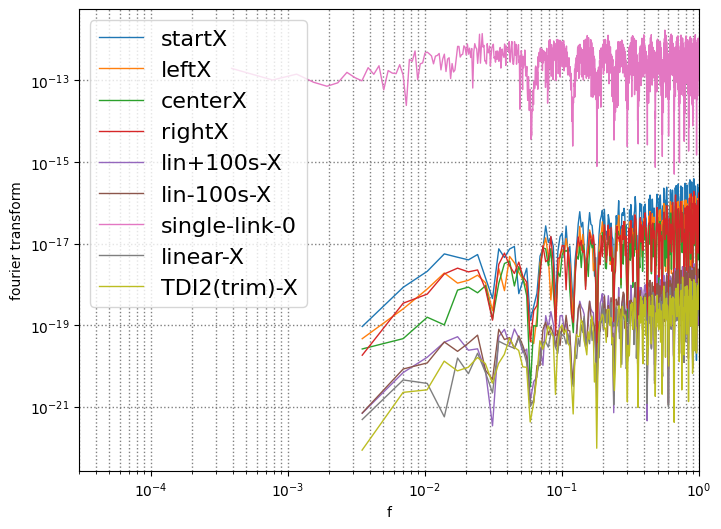

In [23]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 100
i0=iev

ixyz=0

#f,data=do_ft(XYZ_file_noise)
#axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset)):
    f,data=do_ft(XYZset[iset])
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label=nameset[iset]+'XYZ'[ixyz])
               


if 0:
    f,data=do_ft(XYZlin_pk)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin+1ks-'+'XYZ'[ixyz])
    f,data=do_ft(XYZlin_mk)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin-1ks-'+'XYZ'[ixyz])

if 1:
    f,data=do_ft(XYZlin_pc)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin+100s-'+'XYZ'[ixyz])
    f,data=do_ft(XYZlin_mc)
    axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='lin-100s-'+'XYZ'[ixyz])
        
for iy in range(1):
    f,data=do_ft(y_n)
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))

f,data=do_ft(XYZlin)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='linear-'+'XYZ'[ixyz])

f,data=do_ft(TDItest_n)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2(trim)-'+'XYZ'[ixyz])




axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([.3e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()

#### Comments
In the plots above (6hr data test with 2025-04-07-keplerian data) we see that the linear interpolation is effective in basically matching the pytdi result, an about a factor of 100 better than the fixed centered kernel.

Even shifting the kernel time assignments by 100s leads to something like a factor of 2 degradation in the result.  Previously, using the "t_eval_set" the error was asymmetric for a forward vs reverse shift suggesting that our nominal time alignment was not quite optimal. We shifted to reference times in the center of the
kernel evaluation span for a better fit.

Reflecting on this, we realize that our approach to the reverse engineering of the kernel is based on the assumption that the kernel is constant over the duration of its width, which is about 1 min.  Our kernel is
the coupling of a range of points in the out-channel to a single input point, while we apply the kernel as
the range of input couplings for a single output time. 

### kernel inner product
The difference in channel outcomes relate to the difference in optimal kernels as they change over time.  Can we measure the kernel difference to estimate the rate of change in some direct way?

There are many ways to define and realize an inner product which characterizes the similarity or difference of two filter kernels.  To discuss this, let us specify that and output that the value of sample $i$ of channel $k$ is given by:

$$
z_k^i =  \sum_{\alpha}^{n_{ic}}\sum_{j}^{n_{s}}S_{\alpha k}^j y_{\alpha}^{i-j}
$$

where $y_\alpha^i$ is the $i$-th sample of input channel $\alpha$ and $S_{\alpha k}^j$ are the kernel coefficients.

For independent white noise inputs, $E\left[y_{\alpha}^{i}y_{\beta}^{j}\right]=\delta_{\alpha\beta}\delta_{ij}$ the expected statistics for natural inner product of two channel $\kappa$ and $\lambda$ is then

$$
\begin{align}
E\left[\sum_i^nz_\kappa^iz_\lambda^i\right]&=\sum_i^n\sum_{\alpha}^{n_{ic}}\sum_{l}^{n_{s}}\sum_{\beta}^{n_{ic}}\sum_{m}^{n_{s}}S_{\alpha \kappa}^l S_{\beta \lambda}^m E\left[y_{\alpha}^{i-l}y_{\beta}^{i-m}\right]\\
&=n\sum_{\alpha}^{n_{ic}}\sum_{l}^{n_{s}}S_{\alpha \kappa}^l S_{\alpha \lambda}^{l} 
\end{align}
$$

A natural inner product for the kernel (i.e. the channel definition) itself could then be written:

$$
\left(\mathbf{S}_\kappa,\mathbf{S}_\lambda\right)=\sum_{\alpha}^{n_{ic}}\sum_{l}^{n_{s}}S_{\alpha \kappa}^l S_{\alpha \lambda}^{l}
$$

Generalizations of this can be written for colored and correlated noise inner products weighted in the Fourier domain.

$$
\begin{align}
\left(\mathbf{S}_\kappa,\mathbf{S}_\lambda\right)&=\sum_{k}\left(\tilde z_\kappa^k\right)^*\tilde z_\lambda^j\\
&=\sum_{\alpha}^{n_{ic}}\sum_{\beta}^{n_{ic}}\sum_{k}^{n_{s}}\left(\tilde S_{\alpha \kappa}^l\right)^* \tilde S_{\alpha \lambda}^{l}\Sigma^k_{\alpha\beta} 
\end{align}
$$

Here $\Sigma^k_{\alpha\beta}$ is the cross spectral density of the input channels.  We also note that the Fourier transforms of the kernels are assumed to be computed with zero padding on a grid of the same length as the channel.  We could motivate a different choice of inner product for each assumption about the cross spectral density.

In [24]:
def simplest_kernel_inner_product(kernel1,kernel2):
    #See note above
    pass

### Piecewise linear interpolation

In [25]:
'''
def linear_interp_data(channel_sets,kernel_times):
    #This function produces an output channel set from two input time-domain channel sets by linear interpolation
    #Each of the two input channels is treated as corresponding to a specific kernel_time and the
    #output should match that channel at that time.  At other times, the output is a linar interpolant
    #The output times are the same as channel set times
    times = get_times(channel_sets[0])
    eps = (times-kernel_times[0])/(kernel_times[1]-kernel_times[0])
    return TimeData(channel_sets[0].data*(1-eps) + channel_sets[1].data*eps, channel_sets[0].dt, channel_sets[0].t0, channel_sets[0].names)
'''

def piecewise_linear_apply_filter_set(input_data, filter_set, kernel_times, **filter_kwargs):
    '''
    This function produces an output channel set, based on the input_data, from a set of input time-domain filters by 
    piecewise linear interpolation.

    The filters are expected to be optimized at the corresponding kernel times, and time-ordered.
    Then, working across the time domain, the nearest filters are selected pairwise and linear interpolation
    provides the result for the corresponding times. 
    '''

    # 1. First some consistency checks. All of these might be obviated if controlled separately
    # Times should be ordered
    assert np.all(kernel_times[:-1] < kernel_times[1:]), "Values in kernel_times must be ordered and increasing"
    # Output channels should match
    for i in range(len(filter_set)-1):
        assert fliter_set[i].n_output_channel==filter_set[i+1].n_output_channels and 
                np.all(filter_set[i].output_names==filter_set[i+1].output_names),
                'Output channels do not make for filters '+str(i)+' and '+str(i+1)
    # For simplicity we demand that the kernel stencils be the same for each filter. This isn't strictly necessary
    # for the interpolation to make sense, but it does simplify the calculation a little.  Could be relaxed later.
    nleft=[filt.nleft for filt in filter_set]
    nright=[filt.nright for filt in filter_set]
    assert np.all(nleft[:-1]==[nleft[1:]) and np.all(nright[:-1]==[nright[1:]), "Not all filter stencils match."
    nleft=nleft[0]
    nright=nright[0]
    #Require commensurate dt
    dt=[filt.dt for filt in filter_set]
    assert np.all((dt[:-1]==[dt[1:])),"Not all filter cadences agree."
    dt=dt[0]
    
    # 2. Identify the extent of the 'valid' part of the output time domain.
    output_t0=input_data.t0+nleft*dt
    output_n=input_data.n_samples()-nleft-nright
    
    # 3. Next we need to split the output time domain into a set of subdomains with an assigned pair of nearest filters
    # The subdomains are bounded by the points of nearest kernel times
    kernel_time_indicies=int((kernel_times-output_t0)/dt+0.5)
    select_bounds=np.arange(1,len(kernel_times)-1) #No bound associated with outermost filters since we need filter pairs
    #enforce that internal bounds should be strictly internal
    select_bounds=select_bounds[kernel_time_indices[select_bounds]>0]
    select_bounds=select_bounds[kernel_time_indices[select_bounds]<output_n-1]
    istarts=np.concatenate(([0],kernel_time_indices[internal_bounds]))
    iends=np.concatenate((kernel_time_indices[internal_bounds],[output_n]))
    left_kernel_inds=np.concatenate(([internel_bounds[0]-1],internal_bounds))

    # 4. Now do apply the filter pairs and linearly interpolate to get the output for each subdomain
    left_data=input_data.get_range(istarts[0],iends[0]+nleft+nright)
    
    
        
    sample_times = get_times(channel_sets[0]) #These must be the 
    eps = (times-kernel_times[0])/(kernel_times[1]-kernel_times[0])
    return TimeData(channel_sets[0].data*(1-eps) + channel_sets[1].data*eps, channel_sets[0].dt, channel_sets[0].t0, channel_sets[0].names)



SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2144232654.py, line 34)

## Sensitivity estimates

In [ ]:
from scipy import signal
from pcipy.filter import RestrictedFilter

# Some options and prep for the welch_matrix calc
nperseg = 200000
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}
welch_kwargs['detrend']=None

def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat

def compute_welch_matrix_td(y_td, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    args=kwargs.copy()
    args['fs']=1/y_td.dt
    
    ydata=y_td.data.T
    
    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat

def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)

def estimate_sensitivity(filt, data_n, data_gw, joint=True, welch_kwargs=welch_kwargs, strainPSD=1):
    #Sensitivity is estimated by explicit computation of the ratio of the channel noise and channel simulated GW signal
    #To scale the sensitivity, we need to know the incident strain PSD value (assumed constant here)
    #We understand this as the sum of the plus and cross PSDs for each point source in the simulation
    
    
    if filt is not None:    
        e_n = filt.apply_filter(data_n,method='convolve')
        filtGW=RestrictedFilter(filt,input_names=y_namesGW)
        e_gw = filtGW.apply_filter(data_gw,method='convolve')
            
    else:
        e_n = data_n
        e_gw = data_gw
        
    n_channels=e_n.n_channels()
    print(n_channels,'channels')
    
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_n_mat = compute_welch_matrix_td(e_n, **welch_kwargs)

    # Welch spectrum matrix for PCI variables from noise
    freqs, e_gw_mat = compute_welch_matrix_td(e_gw, **welch_kwargs)

    # Orthogonalization
    _, s, vh = np.linalg.svd(e_n_mat)

    # Apply the orthogonal transformation to the GW signal    
    e_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_gw_mat, np.swapaxes(vh, 1, 2).conj()))

    # Apply the orthogonal transformation to the noise covariance
    e_n_mat_ortho = multiple_dot(vh, multiple_dot(e_n_mat, np.swapaxes(vh, 1, 2).conj()))
    
    factor=strainPSD

    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    sens = np.array([np.abs(e_n_mat_ortho[:, j, j] / e_gw_mat_ortho[:, j, j] * factor) for j in range(n_channels)]).T
    
    if joint:
        print('joining')
        sens = 1 / np.sum(1/np.array(sens), axis=1)
    
    return freqs, sens



In [ ]:
import importlib
import pcipy
importlib.reload(pcipy)
import pcipy.data
importlib.reload(pcipy.filter)
from pcipy.filter import RestrictedFilter

TDIfiltsetGW=[ RestrictedFilter(filt,input_names=y_namesGW,output_names=None) for filt in TDIfiltset ]

XYZsetGW = [ filt.apply_filter(y_gw,method='convolve') for filt in TDIfiltsetGW ]

#ioff=125*0
#eps = np.array([ (ioff-skip+i-istep)/istep for i in range(nsnew)])
#print(eps[skip:skip+ns])
#eps=0.5
#XYZlinGW =  TimeData(XYZset[0].data*(1-eps) + XYZset[1].data*eps, XYZset[0].dt, XYZset[0].t0, XYZset[0].names)
XYZlinGW = linear_interp_data(XYZsetGW[1:4:2],t0set[1:4:2])
#print(XYZlin.data.shape,XYZ.data.shape)


#XYZsetGW_ftt = [ [ fft( wd * XYZsetGW[j].data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(3)] for j in range(2) ]
#XYZsetGW_ftt = [ fft( wd * XYZlinGW.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(3)]
f,XYZlinGW_ftt=do_ft(XYZlinGW)

#XYZleftx_fft=fft(wd * XYZset[0].data[0][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2))
#XYZrightx_fft=fft(wd * XYZset[1].data[0][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2))


In [ ]:
# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
p_tdi2_freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
tdi2_sh=np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)])
mean_tdi2_sh = 1 / np.sum(tdi2_sh, axis=0)
mean_tdi2_sens = [freqs, mean_tdi2_sh]

print(XYZset[2].data.T.shape,e_tdi2_n.shape)

In [ ]:
# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
tdi2_td=TimeData(e_tdi2_n.T,dt=1/fs,t0=skip/fs,names=[name for name in "XYZ"])

freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)
tdi2_gw=TimeData(e_tdi2_gw.T,dt=1/fs,t0=skip/fs,names=[name for name in "XYZ"])



In [ ]:
from pcipy import plotting 
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))



freqs, n_mat = compute_welch_matrix_td(XYZset[2], **welch_kwargs)
_, s, vh = np.linalg.svd(n_mat)
n_mat_ortho = multiple_dot(vh, multiple_dot(n_mat, np.swapaxes(vh, 1, 2).conj()))
freqs, gw_mat = compute_welch_matrix_td(XYZsetGW[2], **welch_kwargs)
gw_mat_ortho = multiple_dot(vh, multiple_dot(gw_mat, np.swapaxes(vh, 1, 2).conj()))

for ichan in range(3):
    cmpt = 'ch'+'123'[ichan]
    axes.loglog(p_tdi2_freqs, 1/tdi2_sh[ichan],
            linewidth=1, label=r'TDI file ortho '+cmpt)
    sens = 1/np.abs(gw_mat_ortho[:,ichan,ichan]/n_mat_ortho[:,ichan,ichan])
    #sens = 1/np.abs(gw_mat_ortho[:,ichan,ichan]/s[:,ichan])
    axes.loglog(freqs, sens,
                linewidth=1, label=r'XYZcenter ortho '+cmpt)

axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"sens")
axes.set_xlim([3e-4, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("strain sensitivity of channel")
plt.show()

In [ ]:
from pcipy import plotting 
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
iplot=0
jplot=0

fac=1e-30

cmpt = 'XYZ'[iplot]+'-'+'XYZ'[jplot]
cmptG = 'XYZ'[iplot]+'-'+'XYZ'[jplot]+' x '+str(fac)
axes.loglog(freqs, np.abs(p_tdi2_n_mat[:,iplot,jplot]),
            linewidth=1, label=r'TDI noise '+cmpt)
axes.loglog(freqs, np.abs(p_tdi2_gw_mat[:,iplot,jplot])*fac,
            linewidth=1, label=r'TDI GW '+cmptG)
if 0:
    x=[np.linalg.det(m) for m in p_tdi2_n_mat]
    axes.loglog(freqs, x,
            linewidth=1, label=r'TDI det')

if 1:
    freqs, n_mat = compute_welch_matrix_td(XYZset[2], **welch_kwargs)
    axes.loglog(freqs, np.abs(n_mat[:,iplot,jplot]),
                linewidth=1, label=r'XYZcenter noise '+cmpt)
    freqs, gw_mat = compute_welch_matrix_td(XYZsetGW[2], **welch_kwargs)
    axes.loglog(freqs, np.abs(gw_mat[:,iplot,jplot])*fac,
                linewidth=1, label=r'XYZcenter GW '+cmptG)
    if 0:
        x=[np.linalg.det(m) for m in n_mat]
        axes.loglog(freqs, x,
            linewidth=1, label=r'TDI det')
    
    if 1:
        _, s, vh = np.linalg.svd(n_mat)
        n_mat_ortho = multiple_dot(vh, multiple_dot(n_mat, np.swapaxes(vh, 1, 2).conj()))
        axes.loglog(freqs, np.abs(n_mat_ortho[:,iplot,jplot]),
                    linewidth=1, label=r'XYZcenter perp noise '+cmpt)
        gw_mat_ortho = multiple_dot(vh, multiple_dot(gw_mat, np.swapaxes(vh, 1, 2).conj()))
        axes.loglog(freqs, np.abs(gw_mat_ortho[:,iplot,jplot])*fac,
                    linewidth=1, label=r'XYZcenter perp GW '+cmptG)
        if 1:
            sens = 1/np.abs(gw_mat_ortho[:,iplot,jplot]/n_mat_ortho[:,iplot,jplot])
            axes.loglog(freqs, sens,
                    linewidth=1, label=r'XYZcenter perp sens ')
        if 0:
            x=[np.linalg.det(m) for m in n_mat_ortho]
            axes.loglog(freqs, x,
                linewidth=1, label=r'TDI det')

axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"P(f)")
axes.set_xlim([3e-4, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("PSD of channel")
plt.show()

In [ ]:
sens_list = []
sens_list += [["TDIfile", estimate_sensitivity(None,XYZ_file_noise, XYZ_file_gw, joint=True)]]
ytestn=get_range(tdi2_td,skip-125,skip+125+ns)
ytestgw=get_range(tdi2_gw,skip-125,skip+125+ns)
sens_list += [["TDIfile[ns]", estimate_sensitivity(None,ytestn,ytestgw,joint=True)]]
sens_list += [[nameset[i], estimate_sensitivity(TDIfiltset[i],ytest_n,ytest_gw,joint=True)] for i in range(2,3)]
sens_list += [["linear", estimate_sensitivity(None,XYZlin,XYZlinGW,joint=True)] ]

#TDIfiltset = [ TDIFilter(data_noise,i0=i) for i in i0set ]



In [ ]:
from pcipy import plotting 
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(mean_tdi2_sens[0], np.sqrt(mean_tdi2_sens[1]), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(sens_list)):
    #print(j)
    axes.loglog(sens_list[j][1][0], np.sqrt(sens_list[j][1][1]), 
                linewidth=1, label=sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([3e-4, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [ ]:
sens_list = []
sens_list += [["TDIfile", estimate_sensitivity(None,tdi2_td, tdi2_gw, joint=False)]]
ytestn=get_range(tdi2_td,skip-125,skip+125+ns)
ytestgw=get_range(tdi2_gw,skip-125,skip+125+ns)
sens_list += [["TDIfile[ns]", estimate_sensitivity(None,ytestn,ytestgw,joint=False)]]
#ytestn=get_range(y_td,skip-125,skip+125+ns)
#ytestgw=get_range(y_gw,skip-125,skip+125+ns)
sens_list += [["center", estimate_sensitivity(TDIfiltset[2],ytest_n,ytest_gw,joint=False)]]
sens_list += [[[None,"left",None,"right"][i], estimate_sensitivity(TDIfiltset[i],ytest_n,ytest_gw,joint=False)] for i in [1,3]]
print(sens_list)

In [ ]:
from pcipy import plotting 
for ix in range(3):
    plotting.plotconfig(lbsize=18, lgsize=16)
    _, axes = plt.subplots(1, 1, figsize=(8, 6))

    axes.loglog(mean_tdi2_sens[0], np.sqrt(1/tdi2_sh[ix]), 
                linewidth=1, label=r'TDI (raw)',
                color='black')
    for j in range(len(sens_list)):
        #print(j)
        axes.loglog(sens_list[j][1][0], np.sqrt(sens_list[j][1][1][:,ix]), 
                    linewidth=1, label=sens_list[j][0], rasterized=True)
    axes.legend(loc='upper left', ncol=2)
    axes.set_xlabel("Frequency [Hz]")
    axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
    axes.set_xlim([1e-3, 1.2])
    #axes.set_ylim([3e-19, 1e-13])
    axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
    axes.set_title("Sensitivity of "+'XYZ'[ix]+" channel")
    plt.show()

### Analytic response sensitivity estimates

#### Single-link response

In [ ]:
import numpy as np
import healpy as hp
import os
from backgrounds import StochasticBackgroundResponse
from lisaorbits import KeplerianOrbits

In [ ]:
nside = 1
npix = hp.nside2npix(nside)
m = np.ones(npix) * np.sqrt((4 * np.pi) / (2 * npix))
sgwb_cls = StochasticBackgroundResponse(m, orbits=orbits)

In [ ]:
display(npix)

In [ ]:
StochasticPointSourceResponse